In [145]:
import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

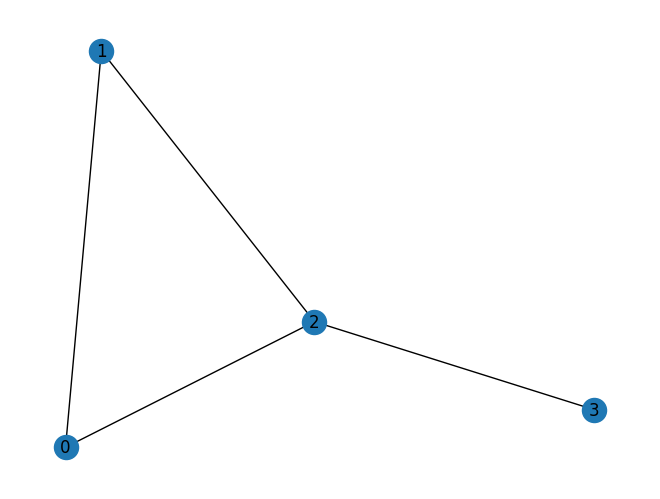

In [146]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

In [147]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian   (-0.25) [Z3]
+ (0.5) [Z0]
+ (0.5) [Z1]
+ (1.25) [Z2]
+ (0.75) [Z0 Z1]
+ (0.75) [Z0 Z2]
+ (0.75) [Z1 Z2]
+ (0.75) [Z2 Z3]
Mixer Hamiltonian   (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


In [148]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [149]:
wires = range(4)
depth = 4


def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    # params[0] is the list of gamma parameters
    # params[1] is the list of alpha parameters
    # they should be the same length as the depth
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [150]:
dev = qml.device("default.qubit", wires=wires)


@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

In [151]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
params = np.array([[0.5]*4]*2, requires_grad=True)

In [152]:
for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[0.19112614 0.46190422 0.80924927 0.05826372]
 [0.31654333 0.40987257 0.09471987 0.7828269 ]]


In [153]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

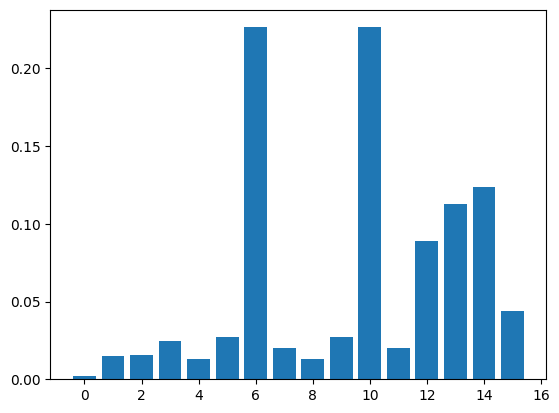

In [154]:
# plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.show()

## Answers are indeed 0110 an 1010